# In this notebook I implement a GP classification experiment in TensorFlow


In [1]:
#%% imports 
from sklearn.cross_validation import train_test_split
from sklearn import datasets
import tensorflow as tf
tf.set_random_seed(54);
import numpy as np
import scipy.io as scio
import numpy.random as rng
import pandas
from sklearn.preprocessing import MinMaxScaler
rng.seed(12)
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Develop the model class

In [2]:
#% GP model
class GP_classification:
    def __init__(self, hyp, X_train, y_train, X_test, y_test):
        self.dataType = tf.float64;
        m, n = X_train.shape;
        mt = X_test.shape[0];
        self.len = m;
        self.X = X_train;
        self.y = np.squeeze(y_train);
        self.Xnew = X_test;
        self.ynew = np.squeeze(y_test);
        
        # kernel with vectors xi and many vectors xjs
        self.kernelfn = lambda xi, xjs: hyp[0]**2 * np.exp(-0.5 * np.sum(((xi - xjs)/ hyp[1])**2))# + hyp[2] * tn.allclose(xi,xjs);
        Kmtx = [];
        for i in range(m):
            Kvct = [];
            for j in range(m):
                Kvct += [self.kernelfn(self.X[i,:], self.X[j,:])];
            Kmtx += [Kvct];
        Kmtx = np.array(Kmtx);
        self.Kmtx = tf.cast(Kmtx, dtype = self.dataType)
        self.invKmtx = tf.cast(np.linalg.inv(Kmtx), dtype = self.dataType);
        
        Kmtx_new = [];
        for i in range(m):
            Kvct = [];
            for j in range(mt):
                Kvct += [self.kernelfn(self.X[i,:], self.Xnew[j,:])];
            Kmtx_new += [Kvct];
        Kmtx_new = np.array(Kmtx_new)
        self.Kmtx_new = tf.cast(Kmtx_new, dtype = self.dataType); 
        
        Kmtx_newii = [];
        for i in range(mt):
            Kmtx_newii += [self.kernelfn(self.Xnew[i,:], self.Xnew[i,:])];
        Kmtx_newii = np.array(Kmtx_newii);
        self.Kmtx_newii = tf.cast(Kmtx_newii, dtype = self.dataType);
        # proposal distribution of z = f(X), z_i~q_i = N(m_i, exp(tau_i)), i \in {1, .... , m}
        self.tiny = 0.*1e-50; # number to be added for numerical stability (setting it to 0 deactivates it)
        self.mu_z = tf.Variable(initial_value= 0. * tf.truncated_normal(shape=[m], stddev = 0.1, dtype=self.dataType));
        self.tau_z = tf.Variable(initial_value= 0. * tf.truncated_normal(shape=[m], stddev = 0.1, dtype=self.dataType));
        self.sigma_z = tf.nn.softplus(self.tau_z) + self.tiny;
        self.z = self.mu_z + tf.random_normal(shape = self.sigma_z.get_shape(), dtype = self.dataType) * self.sigma_z;
        
        self.linkfn = lambda x: 0.5 * (1.0 + tf.erf(x / np.sqrt(2.0))) * (1 - 2e-50) + 1e-50; # probit link function
    ###############################   
    ##### pred_dist: returns the mean and variance of the predictive distribution #####
    def pred_dist(self):
        mu_znew = tf.matmul(tf.matmul(tf.transpose(self.Kmtx_new), self.invKmtx), self.mu_z[:, tf.newaxis]);
        A = tf.diag(self.sigma_z**2);
        sigma_znew = 1.;
#         sigma_znew = tf.sqrt(self.Kmtx_newii[:, tf.newaxis] + tf.diag(tf.matmul(tf.matmul(
#                             self.Kmtx_new.T,  
#                             (self.invKmtx - tf.matmul(tf.matmul(self.invKmtx, A), self.invKmtx))), 
#                             self.Kmtx_new)));
        mu_znew = tf.squeeze(mu_znew);
        sigma_znew = tf.squeeze(sigma_znew);
        return mu_znew, sigma_znew
        
    ##### pred_error: returns the prediction error on test data #####
    def pred_error(self):
        mu_znew, sigma_znew = self.pred_dist();
        pclass1 = self.linkfn(mu_znew);
        est_y = tf.cast(pclass1>0.5, dtype = self.dataType);
        correct = tf.reduce_sum(tf.cast(tf.equal(est_y, self.ynew), dtype=self.dataType))/tf.cast(tf.shape(self.ynew)[0], dtype = self.dataType);
        per_error = (1.-correct)*100.;
        return per_error

    ##################################
    ##### logprior_prob: returns the log prior probability of the latent z #####
    def logprior_prob(self, z):
        #"""the prior = p(z) = N(0, K)"""
        z = z[:, tf.newaxis]
        logprior = -0.5 * tf.matmul(tf.matmul(tf.transpose(z), self.invKmtx), z) - tf.cast(0.5 * tf.log(tf.matrix_determinant(self.Kmtx)), dtype = self.dataType) - tf.cast((self.len/2.) * tf.log(2. * np.pi), dtype = self.dataType);
        return tf.squeeze(logprior)
    ##### loglik_prob: returns the log likelihood probability of the latent z #####
    def loglik_prob(self, z):
        #"""the log likelihood is bernaulli with two classes"""
        pclass1 = self.linkfn(z); # probability of class 1 of size number of observations
        loglik = tf.reduce_sum(self.y * tf.log(pclass1) + (1-self.y) * tf.log(1-pclass1));
        return loglik
    
    ##### logjoint_prob: returns the log joint probability (unnormalized posterior) of the latent z #####
    def logjoint_prob(self, z):
        logjoint = self.logprior_prob(z) + self.loglik_prob(z);
        return logjoint
    ##### logq_prob: returns the log of the proposal probability of the latent z #####
    def logq_prob(self, z):
        #""" Mean field proposal distribution which is the same as the posterior approximate"""
        logq = -0.5 * tf.reduce_sum(((z-self.mu_z)/self.sigma_z)**2)- tf.reduce_sum(tf.log(self.sigma_z)) - tf.cast((self.len/2. * np.log(2. * np.pi)), dtype = self.dataType);
        return logq
    
    ##### sample_model: function used to sample from the proposal distribution and return the probability of all model elements #####
    def sample_model(self, nsamples):
        z = [];
        logprior_prob = [];
        loglik_prob = [];
        logjoint_prob = [];
        logq_prob = [];
        for i in range(nsamples):
            z += [self.mu_z + tf.random_normal(shape = self.sigma_z.get_shape(), dtype = self.dataType) * self.sigma_z];
            #"z is the latent variable: value of the GP function f"
            logprior_prob += [self.logprior_prob(z[i])];
            loglik_prob += [self.loglik_prob(z[i])];
            logjoint_prob += [self.logjoint_prob(z[i])];
            logq_prob += [self.logq_prob(z[i])];
        return tf.pack(logprior_prob), tf.pack(loglik_prob), tf.pack(logjoint_prob), tf.pack(logq_prob), tf.pack(z)


# Generate some data

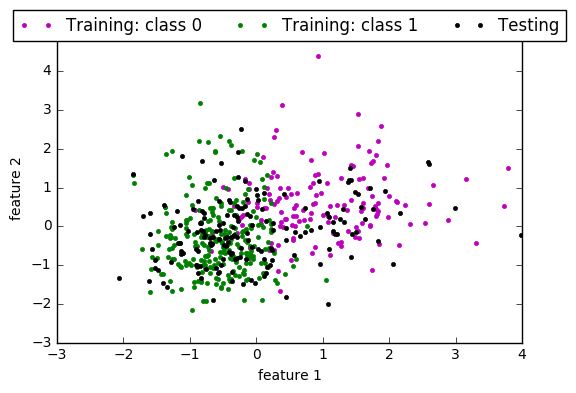

In [3]:
#%% divide the data to training and testing sets
bc = datasets.load_breast_cancer();
Data = [0.]*2;
Data[0] = bc.data;
Data[1] = bc.target;

X_train, X_test, y_train, y_test = train_test_split(Data[0],Data[1], test_size = 0.3)
X_test = (X_test- X_train.mean(axis = 0))/X_train.std(axis = 0)
X_train = (X_train-X_train.mean(axis = 0))/X_train.std(axis = 0)
num_samples, num_features = X_train.shape
Data_train = [X_train, y_train];
Data_test = [X_test, y_test];
_, ax = plt.subplots()
ax.plot(Data_train[0][Data_train[1]==0,0], Data_train[0][Data_train[1]==0,1], 'm.', label = 'Training: class 0')
ax.plot(Data_train[0][Data_train[1]==1,0], Data_train[0][Data_train[1]==1,1], 'g.', label = 'Training: class 1')
ax.plot(Data_test[0][Data_test[1]==0,0], Data_test[0][Data_test[1]==0,1], 'k.', label = 'Testing')
ax.plot(Data_test[0][Data_test[1]==1,0], Data_test[0][Data_test[1]==1,1], 'k.')
ax.legend(loc=9,bbox_to_anchor=(0.5, 1.1), ncol=3)
ax.set(xlabel = 'feature 1', ylabel = 'feature 2')
plt.show(ax)

# Build inference function based on variational bayes (VB)

In [4]:
nsamples = 1;
hyp =[1., 1., 1e-20];
dataSizes = [X_train.shape[0], X_train.shape[1], X_test.shape[0]];

mdl = GP_classification(hyp, X_train, y_train, X_test, y_test);
# # # ## VB_objective 
logprior_prob, loglik_prob, logjoint_prob, logq_prob, z = mdl.sample_model(nsamples)
ELBO =  tf.reduce_mean(logjoint_prob - logq_prob);


In [5]:
learning_rate = 0.1;
optimizer = tf.train.AdamOptimizer(learning_rate)
# optimizer = tf.train.GradientDescentOptimizer(learning_rate)
cost = -ELBO;
tvars = tf.trainable_variables()
grads = tf.gradients(cost, tvars);
grads, _ = tf.clip_by_global_norm(grads, 10)
grads_and_vars = zip(grads, tvars);
train_step = optimizer.apply_gradients(grads_and_vars)
sess = tf.InteractiveSession()

def trainfn(train_step):
    sess.run(train_step);
    return sess.run(cost);
init = tf.global_variables_initializer()


# optimize proposal distribution by maximizing the evidence lower bound expression

In [6]:
max_iter = 100;
pererror = []
cost_value = []
sess.run(init);
for i in range(max_iter):
    cost_value.append(trainfn(train_step))
    pererror.append(sess.run(mdl.pred_error()));
#     print("iter %d, cost %.3f,  error on test data %.2f %%" %(i+1, cost_value[i], pererror[i]))


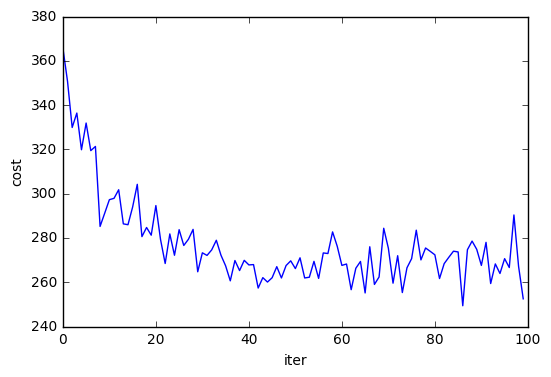

In [7]:
plt.plot(cost_value)
plt.xlabel('iter')
plt.ylabel('cost')
plt.show()

In [ ]:
plt.plot(pererror)
plt.xlabel('prediction error (%)')
plt.ylabel('cost')
plt.show()